# Test the part of variance lost while making spectra with time window processing

In [1]:
import scipy.fft as fft
import scipy.signal as sg
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

## With fft
We refind the 0.375 value 

In [2]:
n = 1024
x = np.random.randn(n)

In [3]:
np.mean(x**2)

0.9490869381743088

In [4]:
fftxhann = fft.fft(x * sg.hann(n))
fftx = fft.fft(x)

In [5]:
print(np.sum(abs(fftx) ** 2) / n**2, np.sum(abs(fftxhann) ** 2) / n**2)

0.9490869381743088 0.3493042106267502


In [6]:
3 / 8

0.375

## With periodogram 
Seems corrected, but how ??

In [49]:
l = []
for i in range(10000):

    n = 1024
    x = np.random.randn(n)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})

    fhann, Ehann = sg.periodogram(
        x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    df = np.diff(fhann)[0]
    # print(np.sum(E), np.sum(Ehann),np.sum(Ehann)/np.sum(E))
    l.append(np.sum(Ehann) * df / np.mean(x**2))
print(np.mean(l))

1.0002061309545534


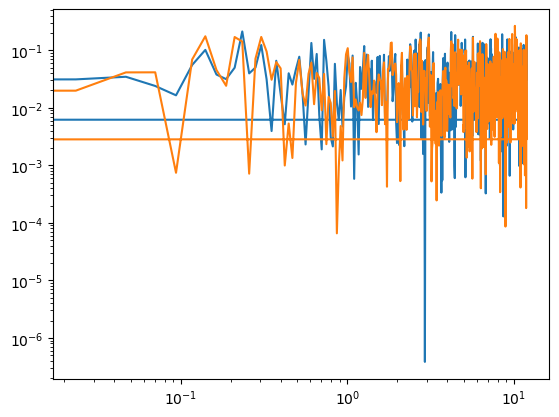

In [8]:
plt.plot(f, E)
plt.plot(fhann, Ehann)
plt.xscale("log")
plt.yscale("log")

In [9]:
?sg.periodogram

Signature:
sg.periodogram(
    x,
    fs=1.0,
    window='boxcar',
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
)
Docstring:
Estimate power spectral density using a periodogram.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window and its length must be nperseg. Defaults
    to 'boxcar'.
nfft : int, optional
    Length of the FFT used. If `None` the length of `x` will be
    used.
detrend : str or function or `False`, optional
    Specifies how to detrend each segment. If `detrend` is a
 

In [50]:
l = []
for i in range(1000):

    n = 1024
    t = 1 / 24 * np.arange(n)
    x = (
        sum([np.sin(2 * np.pi * t / T) for T in np.array([1, 6, 12, 24, 5]) / 24])
        + np.random.randn(n) * 0.4
    )
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})

    fhann, Ehann = sg.periodogram(
        x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    df = np.diff(fhann)[0]
    # print(np.sum(E), np.sum(Ehann),np.sum(Ehann)/np.sum(E))
    l.append(np.sum(Ehann) * df / np.mean(x**2))
print(np.mean(l))

0.9999616487414547


## With time window

[1.588475   1.67298615 1.66082061 1.60131665 1.5896419  1.58857788
 1.54095903 1.5373043  1.58796429 1.66196919 1.69578583 1.59960555
 1.49649597 1.54797005 1.69627282 1.71824735 1.56090975 1.49399206
 1.67628744 1.78496888 1.73138793 1.66450247 1.64487437 1.71256358
 1.76560579 1.71002465 1.75278316 1.69635092 1.65478596 1.74774921
 1.72084393 1.69412169 1.64594441 1.65941608 1.67640079 1.65795719
 1.65837348 1.64385515]
[1.50911779 1.6507624  1.63195597 1.61025891 1.51032387 1.60137403
 1.58966256 1.47987321 1.61998106 1.75241688 1.64335107 1.70009536
 1.39607839 1.59609971 1.62304699 1.77053047 1.50034168 1.50236103
 1.58756918 1.90572258 1.76311416 1.68662393 1.59323858 1.67689373
 1.83121921 1.65657894 1.69568031 1.80822568 1.65182927 1.679107
 1.74890532 1.71081963 1.63581207 1.69547957 1.63960107 1.61672236
 1.73635005 1.66694938]


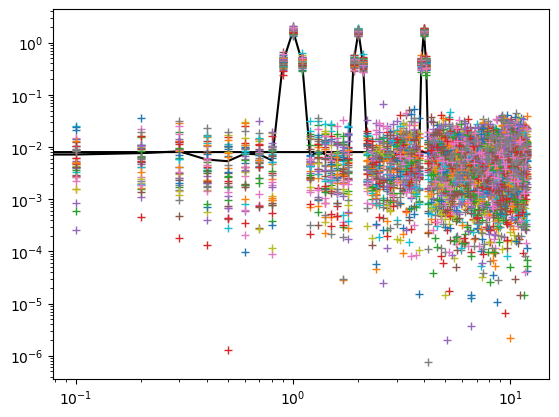

In [105]:
n = 24 * 200
t = 1 / 24 * np.arange(n)
x = (
    sum(
        [
            np.sin(2 * np.pi * t / T)
            for T in np.array(
                [
                    1,
                    6,
                    12,
                    24,
                ]
            )
            / 24
        ]
    )
    + np.random.randn(n) * 0.4
)

imin, imax = 0, len(t)
T = 10 * 24
dt = 1 / 24
overlap = 0.5

i = imin
_X = []
_T = []
_F = []
_Ehann = []
while i + T < imax:
    _x = x[i : i + T]
    _t = t[i : i + T]
    # msx = np.mean(_x**2)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # print(i)
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})
    fhann, Ehann = sg.periodogram(
        _x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    _X.append(_x)
    _T.append(_t)
    _F.append(fhann)
    _Ehann.append(Ehann)
    i += int(T * (1 - overlap))
_X = np.array(_X)
_F = np.array(_F)
_T = np.array(_T)
_Ehann = np.array(_Ehann)

_msX = np.mean(_X**2, axis=1)
df = np.diff(_F, axis=1)[0, 0]
_msE = np.sum(_Ehann, axis=1) * df

print(_msX)
print(_msE)

E = np.mean(_Ehann, axis=0)
plt.plot(_F[0, :], E, color="k")
for i in range(np.shape(_X)[0]):
    plt.plot(_F[i, :], _Ehann[i, :], ls="", marker="+")
plt.xscale("log")
plt.yscale("log")

[1.61297917 1.57573295 1.60823638 1.6031816  1.58455951 1.6657361
 1.68418324 1.6956969  1.72439164 1.71274061 1.68106305 1.65374281]
[1.66324457 1.66324457 1.66324457 1.66324457 1.66324457 1.66324457
 1.66324457 1.66324457 1.66324457 1.66324457 1.66324457 1.66324457]


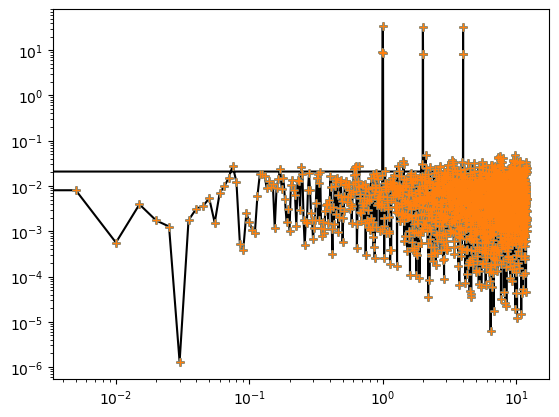

In [106]:
n = 24 * 200
t = 1 / 24 * np.arange(n)
# x = sum([np.sin(2*np.pi*t/T) for T in np.array([1,6,12,24,])/24])+ np.random.randn(n)*0.4

imin, imax = 0, len(t)
T = 30 * 24
dt = 1 / 24
overlap = 0.5

i = imin
_X = []
_T = []
_F = []
_Ehann = []
while i + T < imax:
    _x = x[i : i + T]
    _t = t[i : i + T]
    # msx = np.mean(_x**2)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # print(i)
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})
    fhann, Ehann = sg.periodogram(
        x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    _X.append(_x)
    _T.append(_t)
    _F.append(fhann)
    _Ehann.append(Ehann)
    i += int(T * (1 - overlap))
_X = np.array(_X)
_F = np.array(_F)
_T = np.array(_T)
_Ehann = np.array(_Ehann)

_msX = np.mean(_X**2, axis=1)
df = np.diff(_F, axis=1)[0, 0]
_msE = np.sum(_Ehann, axis=1) * df

print(_msX)
print(_msE)

E = np.mean(_Ehann, axis=0)
plt.plot(_F[0, :], E, color="k")
for i in range(np.shape(_X)[0]):
    plt.plot(_F[i, :], _Ehann[i, :], ls="", marker="+")
plt.xscale("log")
plt.yscale("log")

[1.61060778 1.59639795 1.63437138 1.70428744 1.70272734]
[1.66324457 1.66324457 1.66324457 1.66324457 1.66324457]


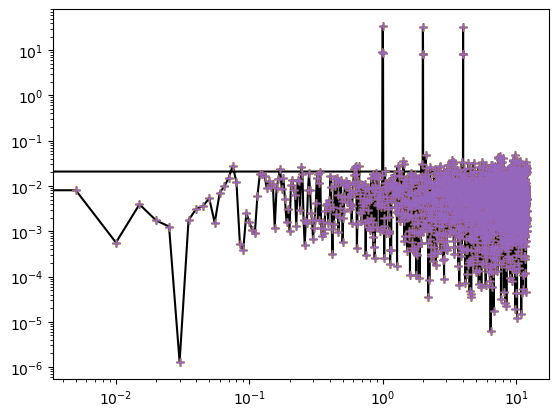

In [107]:
n = 24 * 200
t = 1 / 24 * np.arange(n)
# x = sum([np.sin(2*np.pi*t/T) for T in np.array([1,6,12,24,])/24])#+ np.random.randn(n)*0.4

imin, imax = 0, len(t)
T = 60 * 24
dt = 1 / 24
overlap = 0.5

i = imin
_X = []
_T = []
_F = []
_Ehann = []
while i + T < imax:
    _x = x[i : i + T]
    _t = t[i : i + T]
    # msx = np.mean(_x**2)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # print(i)
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})
    fhann, Ehann = sg.periodogram(
        x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    _X.append(_x)
    _T.append(_t)
    _F.append(fhann)
    _Ehann.append(Ehann)
    i += int(T * (1 - overlap))
_X = np.array(_X)
_F = np.array(_F)
_T = np.array(_T)
_Ehann = np.array(_Ehann)

_msX = np.mean(_X**2, axis=1)
df = np.diff(_F, axis=1)[0, 0]
_msE = np.sum(_Ehann, axis=1) * df

print(_msX)
print(_msE)

E = np.mean(_Ehann, axis=0)
plt.plot(_F[0, :], E, color="k")
for i in range(np.shape(_X)[0]):
    plt.plot(_F[i, :], _Ehann[i, :], ls="", marker="+")
plt.xscale("log")
plt.yscale("log")

[1.13342021 0.27573499 1.17304941 2.02588514 1.1470832  0.30700479
 1.11862077 1.9489238  1.15388007 0.33134926 1.18388078 2.0108045
 1.14740351 0.31029027 1.17258239 2.03610609 1.17148722 0.30198147
 1.12184118 1.97454321 1.14600096 0.29436479 1.1184877  1.98355274
 1.15656366 0.29872667 1.12658656 1.9779214  1.15179265 0.29838948
 1.16519994 2.02446846 1.17698563 0.32286306 1.16015139 2.00668999
 1.17528665 0.31812568]
[1.34124371 0.21085436 1.38581821 1.30319024 1.37513377 0.22918434
 1.41256895 1.18876904 1.43820631 0.22388592 1.43475899 1.23903029
 1.4135701  0.24503699 1.40610127 1.25809032 1.43198185 0.20889737
 1.38134271 1.20243442 1.43999745 0.21560662 1.35915737 1.23219473
 1.44526158 0.1934581  1.33851046 1.26258307 1.40476045 0.20164206
 1.41767184 1.30560004 1.4346815  0.2218019  1.47229453 1.19547582
 1.46043316 0.23177308]


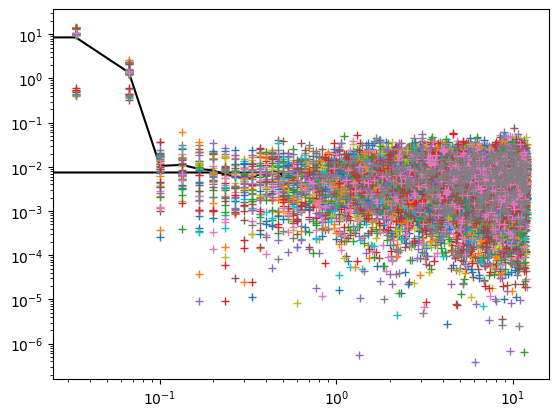

In [108]:
n = 24 * 30 * 20
t = 1 / 24 * np.arange(n)
x = (
    sum([np.sin(2 * np.pi * t / T) for T in np.array([24 * 30, 24 * 60]) / 24])
    + np.random.randn(n) * 0.4
)

imin, imax = 0, len(t)
T = 30 * 24
dt = 1 / 24
overlap = 0.5

i = imin
_X = []
_T = []
_F = []
_Ehann = []
while i + T < imax:
    _x = x[i : i + T]
    _t = t[i : i + T]
    # msx = np.mean(_x**2)
    dt = 1 / 24

    dkwargs = {
        # "window": "hann",
        "return_onesided": False,
        "detrend": False,
        "scaling": "density",
    }
    # print(i)
    # f, E = sg.periodogram(x, fs=1 / dt, axis=0, **dkwargs)
    dkwargs.update({"window": "hann"})
    fhann, Ehann = sg.periodogram(
        _x,
        fs=1 / dt,
        axis=0,
        **dkwargs,
    )
    _X.append(_x)
    _T.append(_t)
    _F.append(fhann)
    _Ehann.append(Ehann)
    i += int(T * (1 - overlap))
_X = np.array(_X)
_F = np.array(_F)
_T = np.array(_T)
_Ehann = np.array(_Ehann)

_msX = np.mean(_X**2, axis=1)
df = np.diff(_F, axis=1)[0, 0]
_msE = np.sum(_Ehann, axis=1) * df

print(_msX)
print(_msE)

E = np.mean(_Ehann, axis=0)
plt.plot(_F[0, :], E, color="k")
for i in range(np.shape(_X)[0]):
    plt.plot(_F[i, :], _Ehann[i, :], ls="", marker="+")
plt.xscale("log")
plt.yscale("log")